In [11]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree
from pyspark import SparkConf, SparkContext , SQLContext
from pyspark.sql import SparkSession, Row
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.mllib.tree import DecisionTree
from pyspark.mllib.regression import LabeledPoint
import numpy as np
import pandas as pd
import os
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, FloatType
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.functions import when, lit, col


In [12]:
spark = SparkSession.builder.appName("Job1").master("local").getOrCreate()
sc = SparkContext

In [7]:
DATA_PATH = os.path.join("/home/zeefu/Desktop")
FILE_NAME = "housing.csv"
FULL_PATH = os.path.join(DATA_PATH, FILE_NAME)

In [14]:
df = spark.read.option("delimiter", ",").csv(FULL_PATH, header=True, inferSchema=True)

# Take a peak at the data


In [15]:
pd.DataFrame(df.take(5), columns=df.columns)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Make "ocean_proximity" labels Binary 

In [16]:
df = df.na.replace(['NEAR BAY', 'INLAND','<1H OCEAN', 'NEAR OCEAN', 'ISLAND'], ['1','0','1','1','0'], 'ocean_proximity')
df = df.withColumn("ocean_proximity", df.ocean_proximity.cast('int'))

# Statistics for numeric variables

In [17]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'double']

df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
longitude,20640,-119.56970445736148,2.003531723502584,-124.35,-114.31
latitude,20640,35.6318614341087,2.135952397457101,32.54,41.95
housing_median_age,20640,28.639486434108527,12.58555761211163,1.0,52.0
total_rooms,20640,2635.7630813953488,2181.6152515827944,2.0,39320.0
total_bedrooms,20433,537.8705525375618,421.38507007403115,1.0,6445.0
population,20640,1425.4767441860465,1132.46212176534,3.0,35682.0
households,20640,499.5396802325581,382.3297528316098,1.0,6082.0
median_income,20640,3.8706710029070246,1.899821717945263,0.4999,15.0001
median_house_value,20640,206855.81690891474,115395.61587441359,14999.0,500001.0


# Scatterplot: Looking for Correlations 

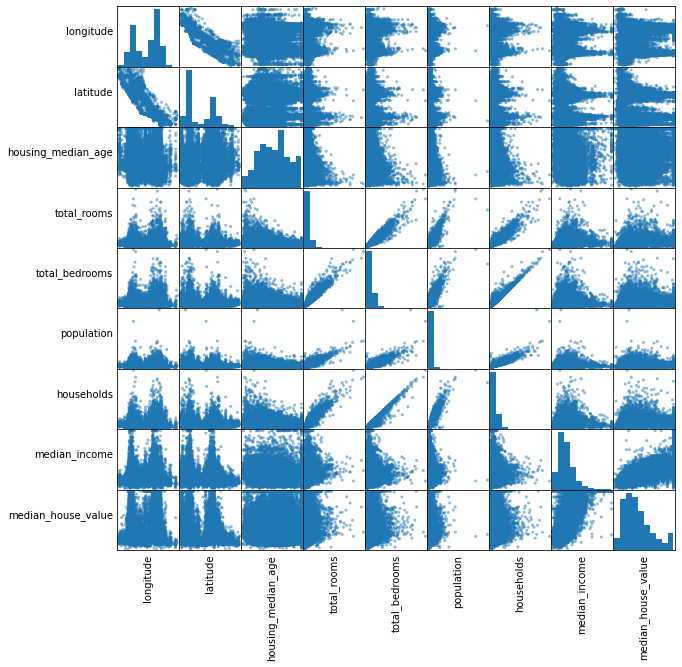

In [51]:
numeric_data = df.select(numeric_features).toPandas()

axs = pd.plotting.scatter_matrix(numeric_data, figsize=(10,10));

n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

# Feature Engineering: Remove null values from dataframe and replace them with the columns median value

In [19]:
# Define function that replaces values with the median or other statistic in dataframe columns

def df_replaced_values(df, value, numeric_features, quantile=False):
     if quantile != False:
          for column_name in numeric_features:
               # replacement value is the median...
               quant = df.approxQuantile(column_name, [0.5], 0)
               df_replaced = df.withColumn(column_name, F.when(F.col(column_name) == value[0], quant).otherwise(F.col(column_name)))
               return df_replaced
          
     else:
          for column_name in numeric_features:
               df_replaced = df.withColumn(column_name, F.when(F.col(column_name) == None, value[1])\
                    .when(F.col(column_name) == value[0], value[1])\
                    .otherwise(F.col(column_name)))
               return df_replaced

In [22]:
df_clean = df_replaced_values(df, value = (0, None), numeric_features= numeric_features, quantile=False) 

Py4JJavaError: An error occurred while calling z:org.apache.spark.sql.functions.when.
: java.lang.RuntimeException: Unsupported literal type class java.util.ArrayList [-118.49]
	at org.apache.spark.sql.catalyst.expressions.Literal$.apply(literals.scala:90)
	at org.apache.spark.sql.catalyst.expressions.Literal$.$anonfun$create$2(literals.scala:152)
	at scala.util.Failure.getOrElse(Try.scala:222)
	at org.apache.spark.sql.catalyst.expressions.Literal$.create(literals.scala:152)
	at org.apache.spark.sql.functions$.typedLit(functions.scala:131)
	at org.apache.spark.sql.functions$.lit(functions.scala:114)
	at org.apache.spark.sql.functions$.when(functions.scala:1373)
	at org.apache.spark.sql.functions.when(functions.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:564)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:832)


In [23]:
numeric_features

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value']